<font size=6><center> Machine Learning - Assignment 1 </center></font>

<font size=5><center> Second dataset: Car Evaluation </center></font>

<font size="4"><center>Author: Mohamed Amine DASSOULI </center></font>

<font size=6> Table of contents: </font>

1. [Importations](#1)
1. [Configuration](#2)
1. [Functions](#3)
1. [Visualizing data](#4)
1. [Data preprocessing](#5)
1. [Prediction models](#6)
    * [Decision Trees](#7)
    * [Artificial Neural Network](#8)
    * [Boosting](#9)
    * [Support Vector Machine](#10)
    * [k-Nearest neighbors](#11)
1. [Comparing the results](#12)

<a id='1'></a>
# Importations

In [186]:
import pandas as pd
import numpy as np 

from numpy.random import seed


%matplotlib inline
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline, BSpline

from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

<a id='2'></a>
# Configuration

In [7]:
PATH_CSV_DATA = "Data/Car_Evaluation.txt"

<a id='3'></a>
# Functions

In [8]:
def encode_column(col: np.ndarray, max_unique_values: int = 100) -> np.ndarray:
    """
    Encode a numpy array
    
    Parameters
    ----------
    col : numpy 1D-Array
    max_unique_values : int, default 100
        Limit the number of unique values to use
        Take the most occurents and regroup all the others in one value

    Returns
    -------
    numpy 2D-Array
        Encoded Array
    
    
    """
    # Get the unique values and their frequences in the list
    col_values = np.unique(col, return_counts=True)
    
    # If there are only two unique values, we use a labelencoder, otherwise we use a onehotencoder
    n_unique_values = len(col_values[0]) 
    if n_unique_values <=2 : 
        labelencoder = LabelEncoder()
        encoded_col = labelencoder.fit_transform(col.reshape((len(col), 1)))
    else:
        # Find the `max_unique_values` most occurent unique values in the column
        col_values = [(val,freq) for (val,freq) in zip(col_values[0], col_values[1])]
        col_values.sort(key=lambda x: x[1])
        values_keep = [col_values[i][0] for i in range(min(max_unique_values, n_unique_values))]
        
        # Keep the most occurent unique values, and change all the others to a value "Others"
        col = np.array([value if value in values_keep else "Others" for value in col])
        
        # Use a hot encoder
        onehotencoder = OneHotEncoder()
        encoded_col = onehotencoder.fit_transform(col.reshape((len(col), 1))).toarray()
    
    return encoded_col

In [231]:
def training_curve(name_model, X_train, y_train, X_test, y_test, num_points=10, smallest_size=5, metric="bal_acc", 
                   smooth=False, title="", map_dict={}):
    # Get number of samples in the training data
    n_samples = X_train.shape[0]
    
    # Initiate the lists that are going to be used for plotting the curve
    curve_X = []
    curve_Y_train = []
    curve_Y_test = []
    curve_loss_train = []
    curve_loss_test = []
    
    for i in np.linspace(smallest_size, n_samples, num_points):
        # Define model
        if name_model == "svm_rbf":
            model_i = svm.SVC(kernel='rbf', gamma=0.1, C=5, random_state=33, probability=True) 
        elif name_model == "svm_poly":
            model_i = svm.SVC(kernel='poly', gamma=0.1, C=1, degree=5, coef0=2, random_state=33, probability=True)  
        elif name_model == "dt":
            model_i = DecisionTreeClassifier(max_depth=6, random_state=13)
        elif name_model == "dt_gini":
            model_i = DecisionTreeClassifier(max_depth=13, random_state=1, min_samples_split=2, criterion="gini")
        elif name_model == "dt_entropy":
            model_i = DecisionTreeClassifier(max_depth=13, random_state=1, min_samples_split=2, criterion="entropy")
        elif name_model == "knn_manhattan":
            model_i = KNeighborsClassifier(n_neighbors=9, p=1)
        elif name_model == "knn_euclidean":
            model_i = KNeighborsClassifier(n_neighbors=9, p=2)
        elif name_model == "knn_minkowski3":
            model_i = KNeighborsClassifier(n_neighbors=9, p=3)
            
        # Fit it using a partition of X_train, y_train
        X_train_i = X_train[:int(i),]
        y_train_i = y_train[:int(i)]
        model_i.fit(X_train_i, y_train_i)
        
        # Make prediction on the train set
        y_proba_train = model_i.predict_proba(X_train)
        y_pred_train = np.array([map_dict[np.argmax(i)] for i in y_proba_train])
        
        # Make prediction on the test set
        y_proba_test = model_i.predict_proba(X_test)
        y_pred_test = np.array([map_dict[np.argmax(i)] for i in y_proba_test])
        
        # Compute balanced accuracy metric
        metric_i_train = balanced_accuracy_score(y_train, y_pred_train)
        metric_i_test = balanced_accuracy_score(y_test, y_pred_test)
        
        # Compute loss
        loss_i_train = log_loss(y_train, y_proba_train)
        loss_i_test = log_loss(y_test, y_proba_test)
        print(i/n_samples)
        
        # Store the result
        curve_X.append(i/n_samples)
        curve_Y_train.append(metric_i_train)
        curve_Y_test.append(metric_i_test)
        curve_loss_train.append(loss_i_train)
        curve_loss_test.append(loss_i_test)

    # Plot the curve for balanced_accuracy_metric
    plt.figure(figsize=(12,8))
    plt.plot(curve_X, curve_Y_train, label="Training set")
    plt.plot(curve_X, curve_Y_test, label="Testing set")
    plt.xlabel("Percentage of the training set used", {"size": 14})
    plt.ylabel("Balanced_accuracy", {"size": 14})
    
    plt.title(title)
    
    plt.legend()
    
    # Plot the curve for the loss
    plt.figure(figsize=(12,8))
    plt.plot(curve_X, curve_loss_train, label="Training")
    plt.plot(curve_X, curve_loss_test, label="Testing")
    plt.xlabel("Percentage of the training set used", {"size": 14})
    plt.ylabel("Cross-entropy Loss", {"size": 14})
    plt.legend()
    

<a id='4'></a>
# Visualizing data

In [141]:
y_train

array(['acc', 'unacc', 'acc', ..., 'acc', 'unacc', 'unacc'], dtype=object)

In [135]:
log_loss(y_test, model_dt.predict_proba(X_test))

0.4982154943641203

In [13]:
headers = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'car']

# Loading data 
df_data = pd.read_csv(PATH_CSV_DATA, names=headers)

# View the dataframe
df_data.head(10)

,buying,maint,doors,persons,lug_boot,safety,car
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


### Basic information

In [14]:
# Visualize basic information about the data
print(f"- Data shape : {df_data.shape}\n")
print(f"- Keys :\n\n{df_data.dtypes}")

- Data shape : (1728, 7)

- Keys :

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
car         object
dtype: object


### Missing data

In [15]:
# Check if there is any missing data 
df_data.isna().any()

buying      False
maint       False
doors       False
persons     False
lug_boot    False
safety      False
car         False
dtype: bool

<font size="3"> ==> There is not any NaN cell. Therefore, there is no missing data ! </font>

### Data balancing

<font size="3"> Let's look at the data and check if there is any imbalance </font>


([<matplotlib.patches.Wedge at 0x7f8f2f1df2d0>,
 [Text(-0.6472108044769336, 0.8894482416466517, 'Unacceptable'),
  Text(0.413550280063065, -1.0193018031278867, 'Acceptable'),
  Text(1.0287904004528587, -0.3893460054194043, 'Good'),
  Text(1.0923282302660486, -0.12968823140070448, 'Very good')],
 [Text(-0.35302407516923645, 0.48515358635271905, '70.02%'),
  Text(0.22557288003439907, -0.5559828017061199, '22.22%'),
  Text(0.5611584002470138, -0.21237054841058414, '3.99%'),
  Text(0.5958153983269355, -0.07073903530947516, '3.76%')])

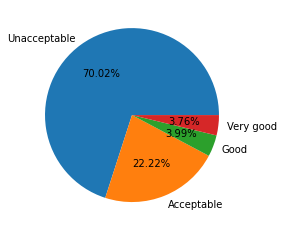

In [20]:
# Calculate the number of clients who exited the bank
num_samples = df_data.shape[0]
classes = pd.value_counts(df_data["car"])
plt.pie(classes.values[:], labels=["Unacceptable", "Acceptable", "Good", "Very good"], autopct=lambda p: f"{p:.2f}%")

<font size='3'> ==> 20 % | 80 % ratio can have an impact on the performance. Thus, we will probably have to resample. </font>

<a id='5'></a>
# Data Preprocessing

<font size="3"> For this dataset, all the features seem to be useful, so we keep all of them.</font>

Let's take a look at the columns <b>'doors' and 'persons'</b> to see how many unique values they have:

In [33]:
df_data.doors.unique()

array(['2', '3', '4', '5more'], dtype=object)

In [34]:
df_data.persons.unique()

array(['2', '4', 'more'], dtype=object)

In [78]:
Categorical_X = df_data.values[:,:-1]
Y = df_data.values[:,-1]

## <font size="3"> Encoding Categorical data :</font>

In [79]:
# Prepare the features
features = []
for i in range(6):
    col_encoded = encode_column(Categorical_X[:,i], 20)
    features.append(np.reshape(col_encoded, (Categorical_X.shape[0], -1)))

X = np.concatenate((features), axis=1)

print(f"Shape of X : {X.shape}")

Shape of X : (1728, 21)


## <font size="3"> Splitting the dataset into training and testing sets :</font>

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10, stratify=Y)

In [158]:
print('Size of train data :', len(X_train))
print('Size of test data :', len(X_test))

Size of train data : 1382
Size of test data : 346


In [159]:
# Create a dictionary to map the indices with the label value
dict_label_ind = {
    0: "acc",
    1: "good",
    2: "unacc",
    3: "vgood"
}

In [162]:
# Switching some samples so that all the 4 values of the label are in the beginning of X_train, y_train
y_train[38], y_train[2] = y_train[2], y_train[38]
X_train[38,], X_train[2,] = X_train[2,], X_train[38,]

y_train[5], y_train[3] = y_train[3], y_train[5]
X_train[5,], X_train[3,] = X_train[3,], X_train[5,]

<a id='6'></a>
# Prediction models

<a id='7'></a>
## Decision Trees

## <font size="3"> Defining the model :</font>

In [164]:
# Create Decision Tree classifer object
model_dt = DecisionTreeClassifier(max_depth=3, random_state=13, min_samples_split=10)

# Train Decision Tree Classifer
model_dt = model_dt.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_dt = model_dt.predict(X_test)

## <font size="3"> Plotting the tree :</font>

[Text(595.1999999999999, 761.04, 'X[12] <= 0.5\ngini = 0.457\nsamples = 1382\nvalue = [307, 55, 968, 52]'),
 Text(446.4, 543.6, 'X[19] <= 0.5\ngini = 0.581\nsamples = 913\nvalue = [307, 55, 499, 52]'),
 Text(297.59999999999997, 326.15999999999997, 'X[3] <= 0.5\ngini = 0.628\nsamples = 607\nvalue = [307, 55, 193, 52]'),
 Text(148.79999999999998, 108.72000000000003, 'gini = 0.623\nsamples = 452\nvalue = [249, 55, 96, 52]'),
 Text(446.4, 108.72000000000003, 'gini = 0.468\nsamples = 155\nvalue = [58, 0, 97, 0]'),
 Text(595.1999999999999, 326.15999999999997, 'gini = 0.0\nsamples = 306\nvalue = [0, 0, 306, 0]'),
 Text(743.9999999999999, 543.6, 'gini = 0.0\nsamples = 469\nvalue = [0, 0, 469, 0]')]

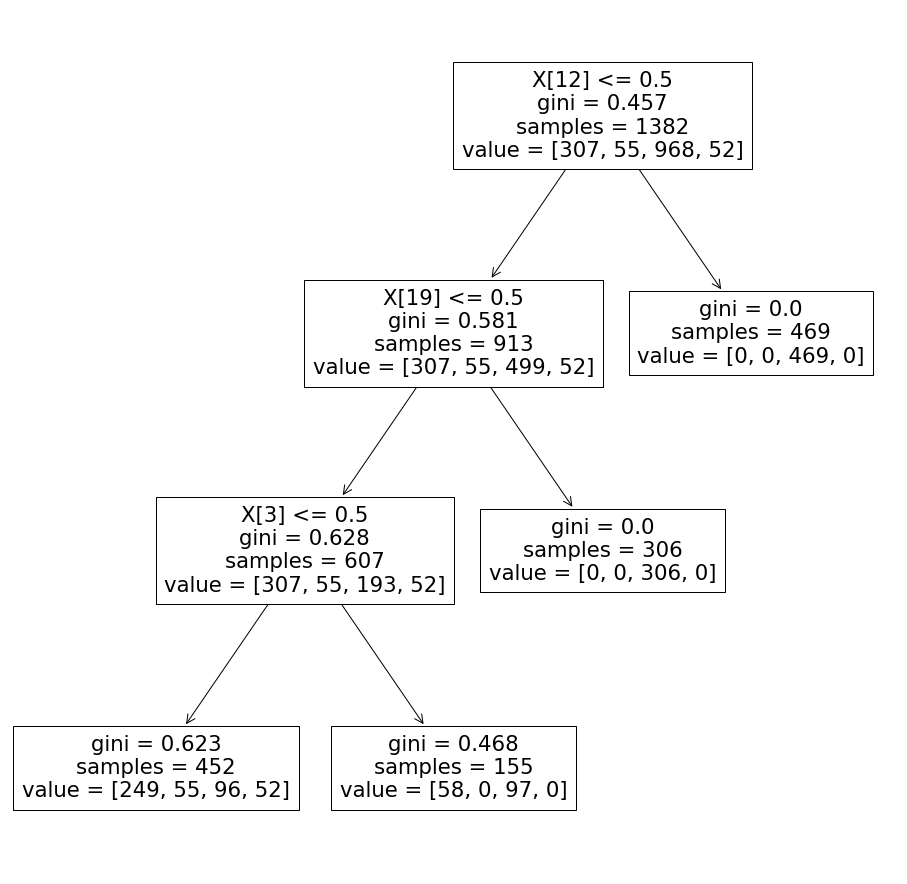

In [165]:
# Plotting the tree
plt.figure(figsize=(16,16))
plot_tree(model_dt)

## <font size="3"> Comparing criterions:</font>

0.00361794500723589
0.05605910579632874
0.10850026658542158
0.16094142737451445
0.21338258816360728
0.2658237489527001
0.318264909741793
0.3707060705308858
0.42314723131997867
0.47558839210907156
0.5280295528981643
0.5804707136872572
0.6329118744763501
0.6853530352654429
0.7377941960545358
0.7902353568436287
0.8426765176327214
0.8951176784218142
0.9475588392109072
1.0


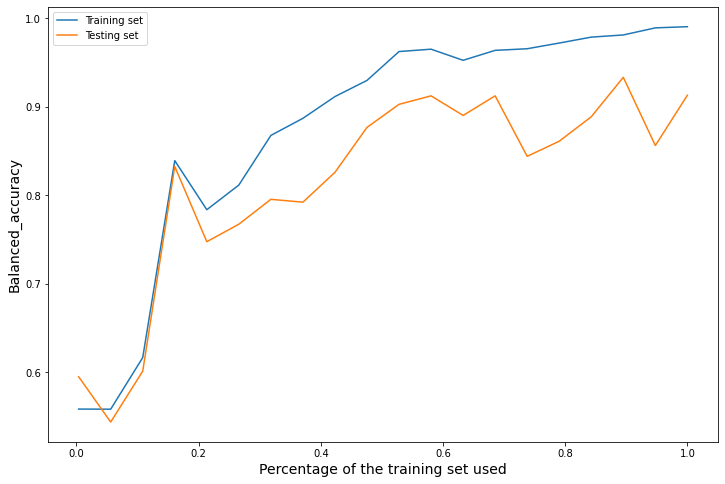

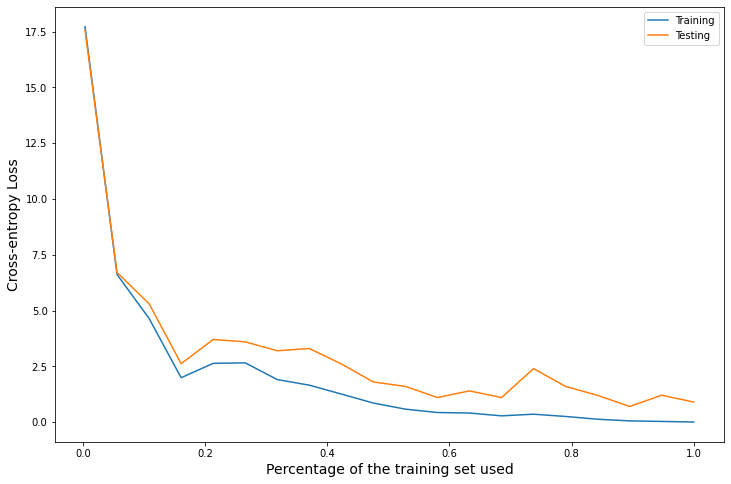

In [170]:
training_curve("dt_entropy", X_train, y_train, X_test, y_test, num_points=20,
               map_dict=dict_label_ind)

0.00361794500723589
0.05605910579632874
0.10850026658542158
0.16094142737451445
0.21338258816360728
0.2658237489527001
0.318264909741793
0.3707060705308858
0.42314723131997867
0.47558839210907156
0.5280295528981643
0.5804707136872572
0.6329118744763501
0.6853530352654429
0.7377941960545358
0.7902353568436287
0.8426765176327214
0.8951176784218142
0.9475588392109072
1.0


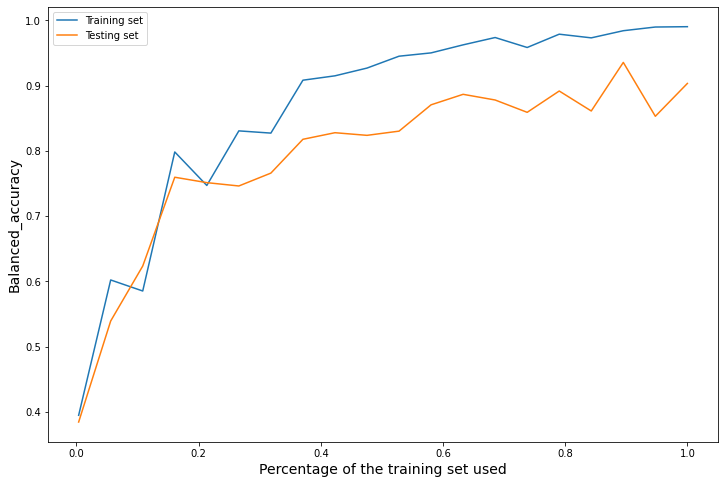

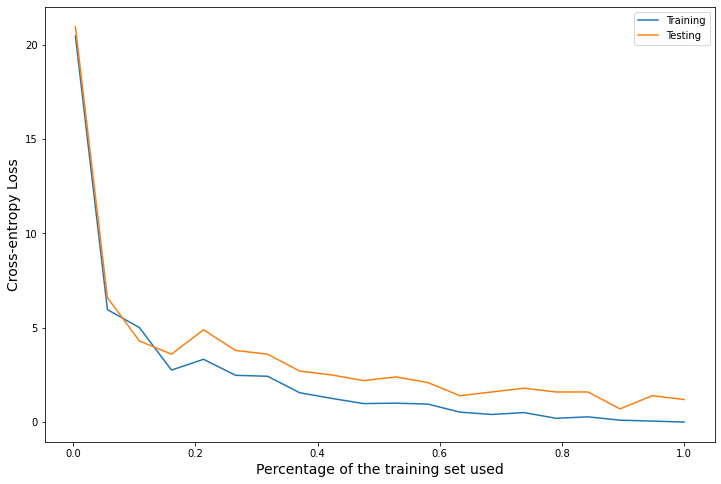

In [172]:
training_curve("dt_gini", X_train, y_train, X_test, y_test, num_points=20, 
               metric="bal_acc", map_dict=dict_label_ind)

<font size="3"> The <b>'gini'</b> criterion works a little bit better than the <b>'entropy'</b>. Now let's do a GridSearch in order to find the best values for max_depth and min_samples_split:</font>

In [174]:
max_depth_values = np.arange(2, 15, 2)
min_samples_split_values = [2, 10, 20, 50, 100]

df_result = np.zeros((len(max_depth_values), len(min_samples_split_values)))

for ind_max_depth in range(len(max_depth_values)):
    for ind_min_samples in range(len(min_samples_split_values)):

        print(ind_max_depth)
        scoring = ['balanced_accuracy']
        clf = DecisionTreeClassifier(criterion="gini",
                                     max_depth=max_depth_values[ind_max_depth],
                                     min_samples_split=min_samples_split_values[ind_min_samples],
                                     random_state=1)

        scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=3)
        mean_score = scores['test_balanced_accuracy'].mean()
        df_result[ind_max_depth, ind_min_samples] = mean_score

print(df_result)

0
0
0
0
0
1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
5
5
5
5
5
6
6
6
6
6
[[0.45014791 0.45014791 0.45014791 0.45014791 0.45014791]
 [0.47550793 0.47550793 0.47550793 0.47550793 0.46785399]
 [0.61904274 0.61796775 0.61745015 0.61964313 0.56093544]
 [0.75708811 0.77182339 0.73202904 0.65729563 0.55805446]
 [0.84788825 0.82947865 0.73035205 0.65729563 0.55805446]
 [0.86532151 0.83111264 0.73035205 0.65729563 0.55805446]
 [0.87018841 0.83111264 0.73035205 0.65729563 0.55805446]]


<font size="3"> The highest value corresponds to  <b>max_depth=14</b> and <b>min_samples_split=2</b>. Let's create our model using those values.</font>

Balanced accuracy:  0.9034374716192899
Test Set:
              precision    recall  f1-score   support

         acc       0.96      0.91      0.93        77
        good       0.92      0.79      0.85        14
       unacc       0.97      1.00      0.98       242
       vgood       0.92      0.92      0.92        13

    accuracy                           0.97       346
   macro avg       0.94      0.90      0.92       346
weighted avg       0.96      0.97      0.96       346

[[ 70   0   6   1]
 [  2  11   1   0]
 [  1   0 241   0]
 [  0   1   0  12]]


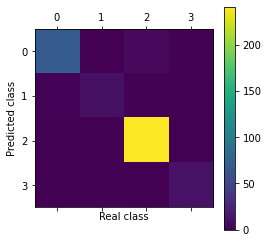

In [175]:
# Create Decision Tree classifer object
model_dt = DecisionTreeClassifier(max_depth=14, random_state=1, min_samples_split=2, criterion="gini")

# Train Decision Tree Classifer
model_dt = model_dt.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_dt = model_dt.predict(X_test)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred_dt))


report = classification_report(y_true=y_test, y_pred=y_pred_dt)
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_dt)
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<font size="3"><b>Pruning:</b></font>

[0.9291617473435655, 0.9259149940968123, 0.8829238942875308, 0.898465171192444, 0.8953659976387249, 0.8953659976387249, 0.8912337662337663, 0.8367882117882117, 0.801073926073926, 0.801073926073926, 0.801073926073926, 0.801073926073926, 0.7312687312687313, 0.671078921078921, 0.5941558441558441, 0.5941558441558441, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5858913813459268, 0.5456021251475797, 0.5456021251475797, 0.5456021251475797, 0.5456021251475797, 0.5456021251475797, 0.4194214876033058, 0.4194214876033058, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.44111570247933884, 0.4411157024793

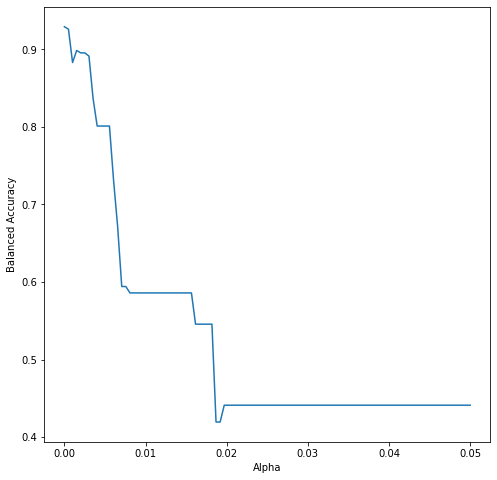

In [176]:
alpha_values = np.linspace(0, 0.05, 100)
df_result = []

for alpha in alpha_values:
    scoring = ['balanced_accuracy']
    clf = DecisionTreeClassifier(criterion="gini",
                                 ccp_alpha=alpha,
                                 random_state=10)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred)
    df_result.append(score)

plt.figure(figsize=(8,8))
plt.xlabel("Alpha")
plt.ylabel("Balanced Accuracy")
plt.plot(alpha_values, df_result)
print(df_result)

<a id='8'></a>
## Artificial Neural network 

## <font size="3"> Defining the model :</font>

In [197]:
seed(1)
# Initialising the ANN
model_ann = keras.models.Sequential()

# Adding the input layer and the first hidden layer
model_ann.add(Dense(units = 16, activation = 'relu', input_dim = X_train.shape[1]))

# Adding a dropout
model_ann.add(Dropout(0.15, seed=5))

# Adding the second hidden layer
model_ann.add(Dense(units = 8, activation = 'relu'))

# Adding a dropout
model_ann.add(Dropout(0.15, seed=5))

# Adding the output layer
model_ann.add(Dense(units = 4, activation = 'softmax'))

# Compiling the ANN
optimizer= Adam(
    learning_rate=0.01
)

model_ann.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'], va)


## <font size="3"> Fitting and testing the model with the imbalanced data :</font>

In [200]:
# Fix seed
seed(10)

# Fit the model
hist = model_ann.fit(X_train, encode_column(y_train), batch_size=32, epochs=100, shuffle=False, 
                    validation_data=(X_test, encode_column(y_test)))


Epoch 1/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0699 - accuracy: 0.9718 - val_loss: 0.0466 - val_accuracy: 0.9798
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.9696 - val_loss: 0.0732 - val_accuracy: 0.9798
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9711 - val_loss: 0.0334 - val_accuracy: 0.9942
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0809 - accuracy: 0.9696 - val_loss: 0.0262 - val_accuracy: 0.9971
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9754 - val_loss: 0.0281 - val_accuracy: 0.9913
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 0.9667 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 0.9761 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 8/100
4

Epoch 59/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9740 - val_loss: 0.0322 - val_accuracy: 0.9855
Epoch 60/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0825 - accuracy: 0.9711 - val_loss: 0.0295 - val_accuracy: 0.9942
Epoch 61/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9703 - val_loss: 0.0298 - val_accuracy: 0.9884
Epoch 62/100
44/44 [==============================] - 0s 2ms/step - loss: 0.1019 - accuracy: 0.9689 - val_loss: 0.0283 - val_accuracy: 0.9913
Epoch 63/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.9826 - val_loss: 0.0472 - val_accuracy: 0.9855
Epoch 64/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0596 - accuracy: 0.9834 - val_loss: 0.0247 - val_accuracy: 0.9942
Epoch 65/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9812 - val_loss: 0.0337 - val_accuracy: 0.9884
Epoch 

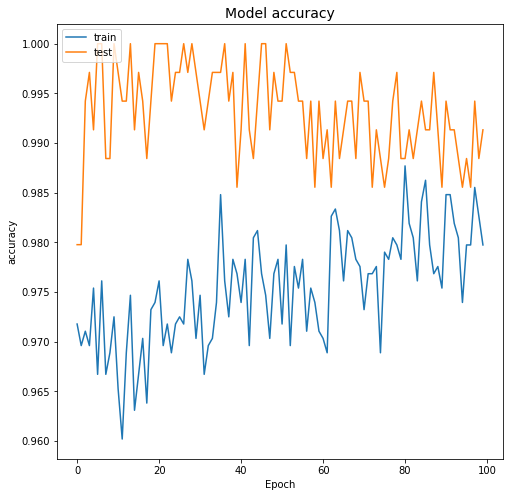

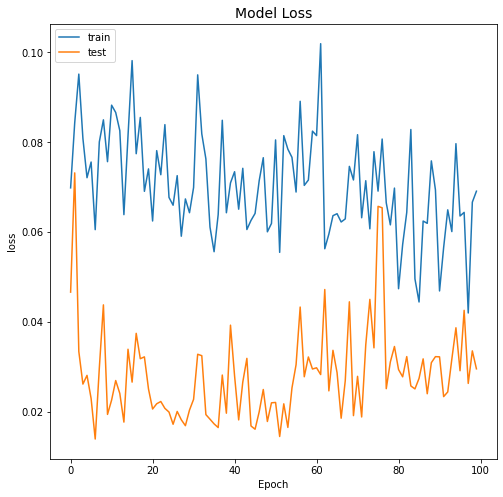

In [202]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy',{"fontsize" : 14})
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Figure for loss 
plt.figure(figsize=(8,8))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss", {"fontsize" : 14})
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')


Balanced accuracy:  0.9756493506493507
Test Set:
              precision    recall  f1-score   support

         acc       1.00      0.97      0.99        77
        good       0.93      0.93      0.93        14
       unacc       1.00      1.00      1.00       242
       vgood       0.87      1.00      0.93        13

    accuracy                           0.99       346
   macro avg       0.95      0.98      0.96       346
weighted avg       0.99      0.99      0.99       346

[[ 75   1   0   1]
 [  0  13   0   1]
 [  0   0 242   0]
 [  0   0   0  13]]


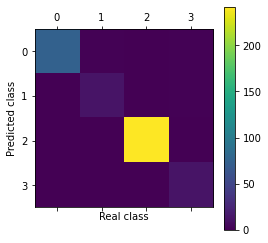

In [206]:
# Predict the response for test dataset
y_pred_ann = np.array([dict_label_ind[np.argmax(i)] for i in model_ann.predict_proba(X_test)])
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred_ann))


report = classification_report(y_true=y_test, y_pred=y_pred_ann)
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_ann)
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<a id='9'></a>
## Boosting

Using boosting on the previous decision tree:

In [207]:
model_boost = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, random_state=10, min_samples_split=100, criterion="gini"), 
    n_estimators=100, random_state=1)

model_boost.fit(X_train, y_train)

model_boost.predict(X_test)


array(['unacc', 'acc', 'vgood', 'acc', 'acc', 'unacc', 'unacc', 'acc',
       'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc',
       'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'acc', 'vgood', 'unacc',
       'unacc', 'unacc', 'unacc', 'acc', 'acc', 'unacc', 'good', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'vgood',
       'unacc', 'unacc', 'acc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc',
       'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc',
       'unacc', 'unacc', 'unacc', 'acc', 'acc', 'unacc', 'acc', 'acc',
       'unacc', 'unacc', 'unacc', 'vgood', 'unacc', 'unacc', 'unacc',
       'unacc', 'acc', 'acc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'acc', 'unacc', 'unacc',
       'good', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc',
       'acc', 'good', 'vgood', 'good', 'unacc', 'unacc', 'unacc', 'unacc',
       'acc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'una

Grid search to determine best number of estimators

Text(0, 0.5, 'Balanced Accuracy')

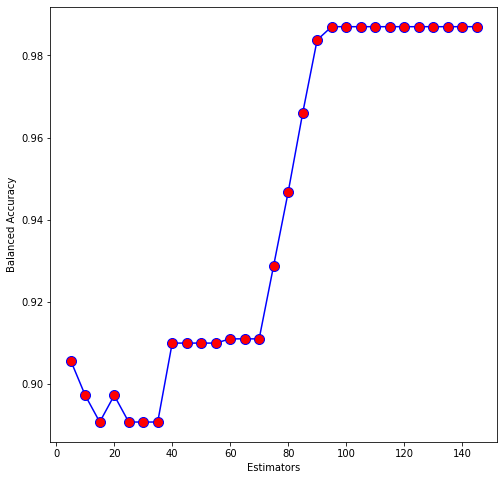

In [211]:
metric_values = []
for i in range(5,150, 5):
    model_boost = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=14, random_state=1, min_samples_split=2, criterion="gini"), 
        n_estimators=i, random_state=1, learning_rate=0.2)
    
    model_boost.fit(X_train,y_train)
    pred_boost = model_boost.predict(X_test)
    score = balanced_accuracy_score(y_test, pred_boost)
    metric_values.append(score)
    
# Plot the curve
plt.figure(figsize=(8,8))
plt.plot(range(5, 150, 5),metric_values, color="blue",
         marker="o", markerfacecolor="red", markersize=10)
plt.xlabel("Estimators")
plt.ylabel("Balanced Accuracy")
    

Balanced accuracy in function of learning rate:

Text(0, 0.5, 'Balanced Accuracy')

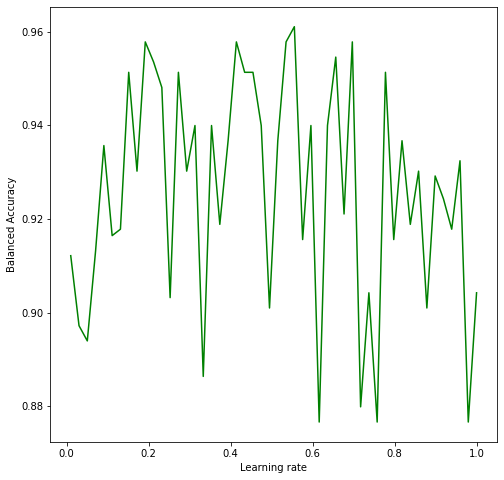

In [213]:
metric_values = []
for i in np.linspace(0.01,1, 50):
    model_boost = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=14, random_state=10, min_samples_split=2, criterion="gini"), 
        n_estimators=100, random_state=1, learning_rate=i)
    model_boost.fit(X_train,y_train)
    pred_boost = model_boost.predict(X_test)
    score = balanced_accuracy_score(y_test, pred_boost)
    metric_values.append(score)
    
# Plot the curve
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0.01,1,50),metric_values, color="green")
plt.xlabel("Learning rate")
plt.ylabel("Balanced Accuracy")
    

Test Set:
              precision    recall  f1-score   support

         acc       0.93      0.97      0.95        77
        good       0.89      0.57      0.70        14
       unacc       1.00      1.00      1.00       242
       vgood       0.93      1.00      0.96        13

    accuracy                           0.98       346
   macro avg       0.94      0.89      0.90       346
weighted avg       0.98      0.98      0.98       346

[[ 75   1   0   1]
 [  6   8   0   0]
 [  0   0 242   0]
 [  0   0   0  13]]


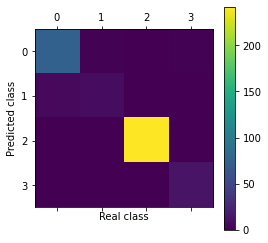

In [237]:
model_boost = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=10, random_state=10, min_samples_split=2, criterion="gini"), 
        n_estimators=120, random_state=1, learning_rate=0.5)
model_boost.fit(X_train,y_train)
y_pred_boost = model_boost.predict(X_test)

report = classification_report(y_true=y_test, y_pred=y_pred_boost)
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_boost)
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<a id='10'></a>
## Support Vector Machine

In [216]:
kernels_b = ['linear','rbf','poly','sigmoid']
kernels = ['rbf', 'poly']

<font size="3">Let's try to determine the kernel to use using a 5-Stratified cross-validation:</font>

In [217]:
for kernel in kernels_b:
    scoring = ['balanced_accuracy']
    clf = svm.SVC(kernel=kernel, random_state=0)
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5)
    mean_score = scores['test_balanced_accuracy'].mean()
    print(f"For {kernel} kernel, the mean balanced accuracy is {mean_score:.4f}")


For linear kernel, the mean balanced accuracy is 0.8636
For rbf kernel, the mean balanced accuracy is 0.9109
For poly kernel, the mean balanced accuracy is 0.9773
For sigmoid kernel, the mean balanced accuracy is 0.5381


<font size="3">Tuning parameters for the rbf kernel (gamma and C):</font>

In [218]:
gamma_values = [0.001, 0.01, 0.1, 1]
C_values = [0.1, 1, 5, 10]

df_result = np.zeros((len(gamma_values), len(C_values)))

for ind_gamma in range(len(gamma_values)):
    for ind_C in range(len(C_values)):
        scoring = ['balanced_accuracy']
        clf = svm.SVC(kernel='rbf', random_state=0, C=C_values[ind_C], gamma=gamma_values[ind_gamma])
        scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=3)
        mean_score = scores['test_balanced_accuracy'].mean()
        df_result[ind_gamma, ind_C] = mean_score

print(df_result)

[[0.25       0.25       0.25       0.3678808 ]
 [0.25       0.35285538 0.58757093 0.76674731]
 [0.25       0.68816473 0.95416302 0.96169597]
 [0.25       0.41888174 0.52427824 0.52427824]]


<font size="3"> The highest value corresponds to <b>gamma=0.1</b> and <b>C=5</b></font>. Using those values, let's build our classifier !

Test Set:
              precision    recall  f1-score   support

         acc       1.00      0.99      0.99        77
        good       0.93      1.00      0.97        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      1.00      1.00        13

    accuracy                           1.00       346
   macro avg       0.98      1.00      0.99       346
weighted avg       1.00      1.00      1.00       346

[[ 76   1   0   0]
 [  0  14   0   0]
 [  0   0 242   0]
 [  0   0   0  13]]


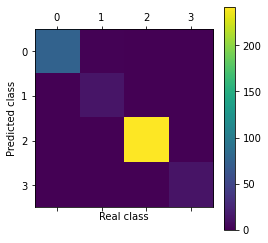

In [221]:
model_svm = svm.SVC(kernel='rbf', gamma=0.1, C=10, probability=True)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict_proba(X_test)
y_pred = np.array([dict_label_ind[np.argmax(i)] for i in y_pred])
report = classification_report(y_true=y_test,y_pred=y_pred)
matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<font size="3"> The highest value corresponds to <b>gamma=0.1</b> and <b>C=5</b></font>. Using those values, let's build our classifier !

0.00361794500723589
0.05605910579632874
0.10850026658542158
0.16094142737451445
0.21338258816360728
0.2658237489527001
0.318264909741793
0.3707060705308858
0.42314723131997867
0.47558839210907156
0.5280295528981643
0.5804707136872572
0.6329118744763501
0.6853530352654429
0.7377941960545358
0.7902353568436287
0.8426765176327214
0.8951176784218142
0.9475588392109072
1.0


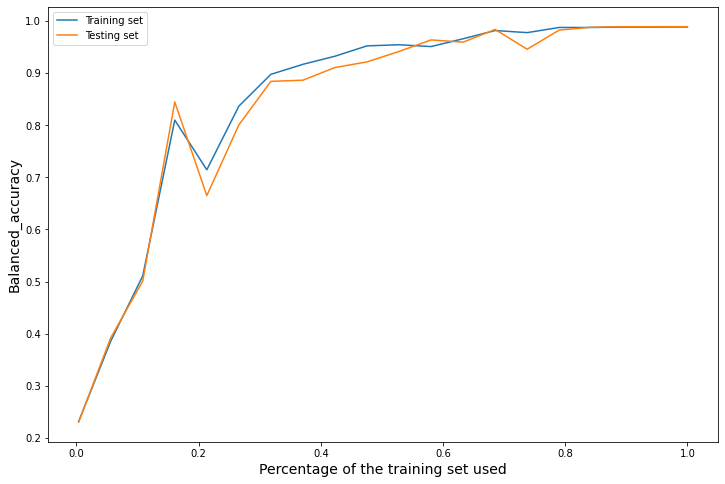

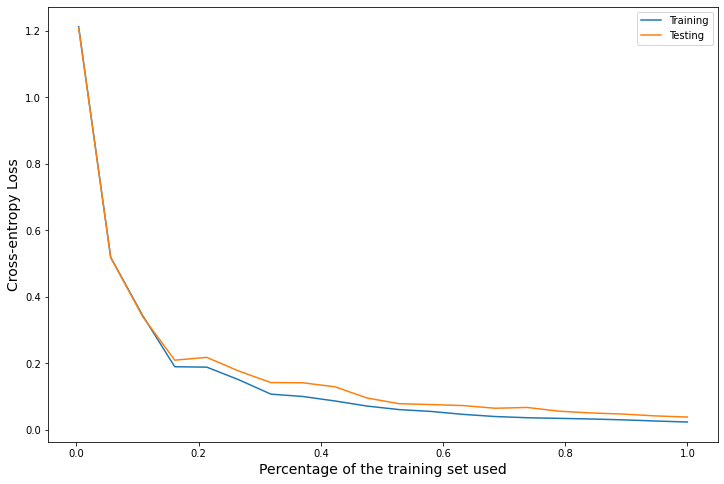

In [224]:
training_curve("svm_rbf", X_train, y_train, X_test, y_test, num_points=20,
               metric="bal_acc", map_dict=dict_label_ind)

<a id='11'></a>
## k-Nearest neighbors

Elbow method:

In [226]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)
model_knn.predict(X_test)

array(['unacc', 'acc', 'vgood', 'unacc', 'acc', 'unacc', 'unacc', 'acc',
       'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc',
       'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'acc', 'acc', 'unacc',
       'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'acc', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'vgood',
       'unacc', 'unacc', 'acc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc',
       'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'vgood', 'unacc', 'acc',
       'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'acc', 'unacc', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'acc', 'unacc',
       'unacc', 'good', 'unacc', 'acc', 'unacc', 'unacc', 'unacc',
       'unacc', 'acc', 'unacc', 'good', 'vgood', 'acc', 'unacc', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc',
 

Text(0, 0.5, 'Error Rate')

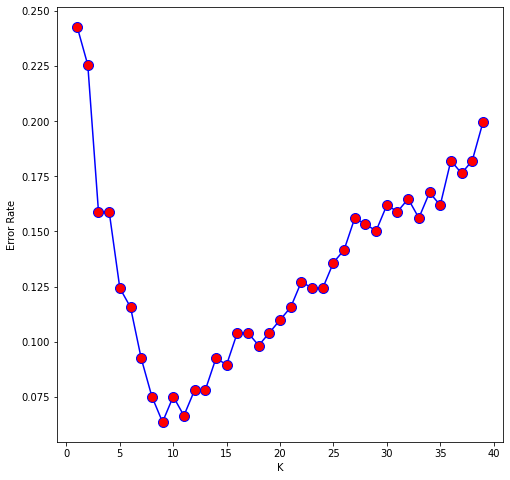

In [227]:
# Calculate error rates for several values of k
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
# Plot the curve
plt.figure(figsize=(8,8))
plt.plot(range(1,40),error_rate, color="blue",
         marker="o", markerfacecolor="red", markersize=10)
plt.xlabel("K")
plt.ylabel("Error Rate")
    

Comparing distances:

0.01447178002894356
0.0663416863432097
0.11821159265747583
0.17008149897174196
0.2219514052860081
0.27382131160027423
0.32569121791454037
0.37756112422880655
0.42943103054307263
0.48130093685733877
0.5331708431716049
0.585040749485871
0.6369106558001372
0.6887805621144033
0.7406504684286694
0.7925203747429355
0.8443902810572017
0.8962601873714678
0.948130093685734
1.0


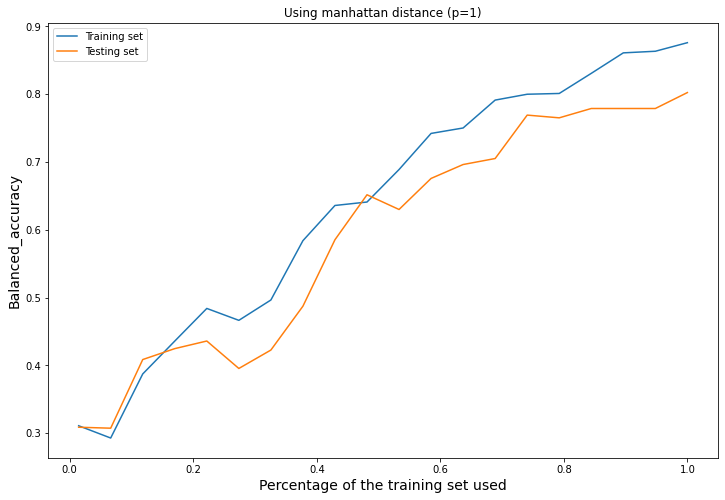

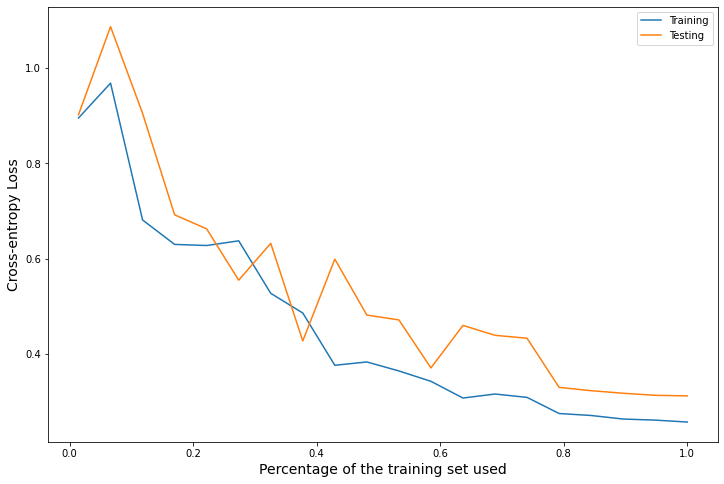

In [232]:
training_curve("knn_manhattan", X_train, y_train, X_test, y_test, smallest_size=20, num_points=20, 
               metric="bal_acc", 
               title="Using manhattan distance (p=1)",
               map_dict=dict_label_ind)

0.01447178002894356
0.0663416863432097
0.11821159265747583
0.17008149897174196
0.2219514052860081
0.27382131160027423
0.32569121791454037
0.37756112422880655
0.42943103054307263
0.48130093685733877
0.5331708431716049
0.585040749485871
0.6369106558001372
0.6887805621144033
0.7406504684286694
0.7925203747429355
0.8443902810572017
0.8962601873714678
0.948130093685734
1.0


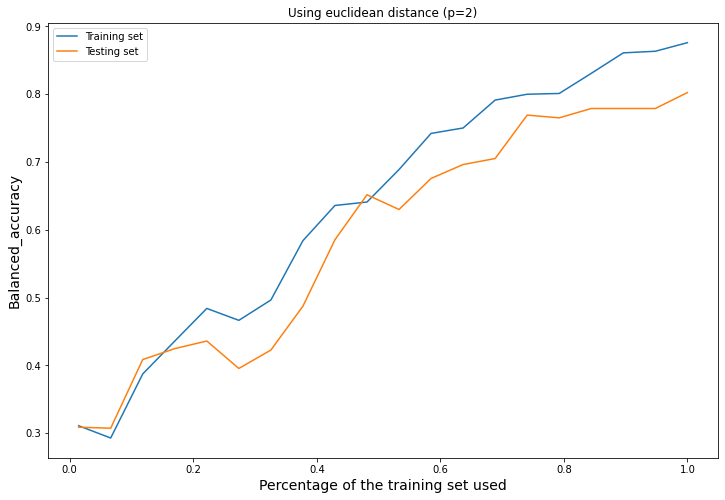

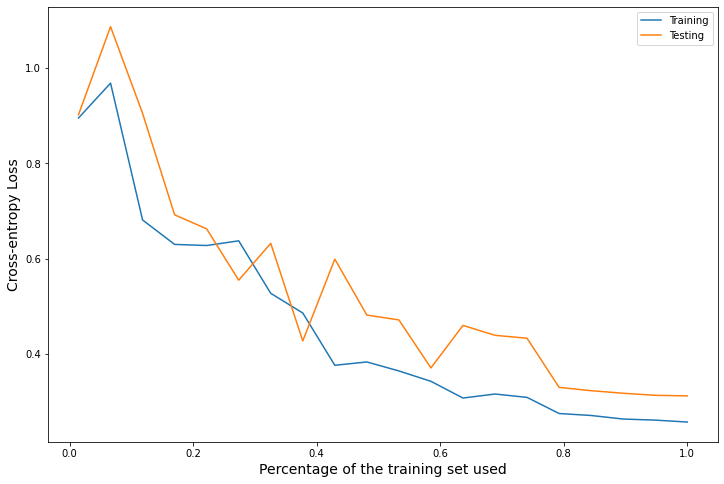

In [233]:
training_curve("knn_euclidean", X_train, y_train, X_test, y_test, smallest_size=20, num_points=20, 
               metric="bal_acc", 
               title="Using euclidean distance (p=2)",
               map_dict=dict_label_ind)

0.01447178002894356
0.0663416863432097
0.11821159265747583
0.17008149897174196
0.2219514052860081
0.27382131160027423
0.32569121791454037
0.37756112422880655
0.42943103054307263
0.48130093685733877
0.5331708431716049
0.585040749485871
0.6369106558001372
0.6887805621144033
0.7406504684286694
0.7925203747429355
0.8443902810572017
0.8962601873714678
0.948130093685734
1.0


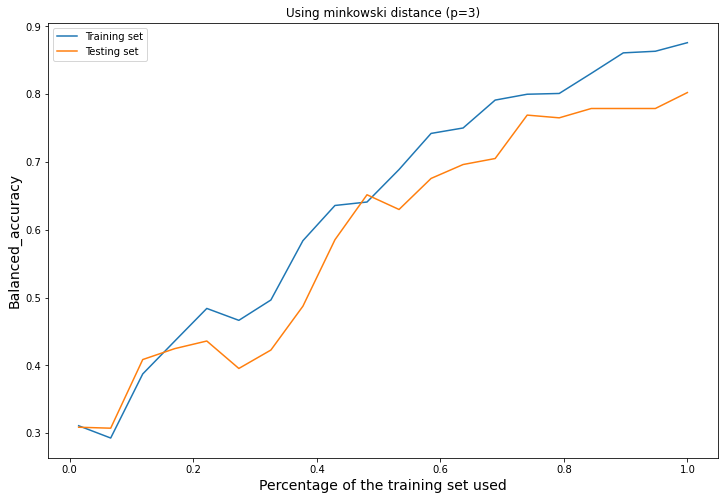

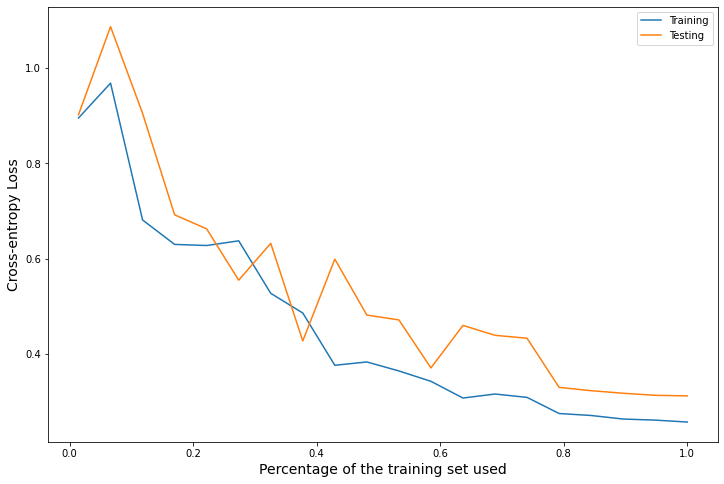

In [234]:
training_curve("knn_minkowski3", X_train, y_train, X_test, y_test, smallest_size=20, num_points=20, 
               metric="bal_acc", title="Using minkowski distance (p=3)",
               map_dict=dict_label_ind)